# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Inteligencia Artificial y Aprendizaje Automático**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **Actividad de la Semana 6**
### **Árboles de decisión y bosque aleatorio.**


**Nombres y matrículas de los integrantes del equipo:**

*   Rodrigo López Aguilera - A01793071
*   Diego Carrera Nicholls - A00464290
*   Guillermo Alfonso Muñiz Hermosillo - A01793101


En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [2]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# para poder aplicar operaciones matemáticas a los datos
from sklearn.compose import ColumnTransformer

# para poder imputar datos faltantes
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, make_scorer

from imblearn.pipeline import make_pipeline

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, validation_curve, learning_curve
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# %matplotlib inline


# **Ejercicio-1.** 
Carga los datos y sustituye los nombres de las columnas del alemán al inglés de acuerdo a como
se indica en la página de la UCI.

In [3]:
# leer los datos de del archivo
df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [4]:
# reemplazar encabezados del alemán al ingles
columns = {'laufkont': 'status', 'laufzeit': 'duration', 'moral': 'credit_history', 'verw': 'purpose', 'hoehe': 'amount',
           'sparkont': 'savings', 'beszeit': 'employment_duration', 'rate': 'installment_rate', 'famges': 'personal_status_sex',
           'buerge': 'other_debtors', 'wohnzeit': 'present_residence', 'verm': 'property', 'alter': 'age', 'weitkred': 'other_installment_plans',
           'wohn': 'housing', 'bishkred': 'number_credits', 'beruf': 'job', 'pers': 'people_liable', 'telef': 'telephone', 'gastarb': 'foreign_worker',
           'kredit': 'credit_risk'}
df.rename(columns=columns, inplace=True)
df.head()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


# **Ejercicio-2.**

Realiza una partición de los datos en el conjunto de entrenamiento del *85%* y el de prueba de *15%*. Los modelos se estarán entrenando con el método de validación cruzada, así que no es
necesario en este paso generar el conjunto de validación. Define como la variable X a todas las variables de entrada y a la variable Y como la variable de salida

In [5]:
y = df['credit_risk']
X = df.loc[:, df.columns != 'credit_risk']

X_train, Xtest, y_train, ytest = train_test_split(X, y, train_size=0.85, random_state=10)

print("X Entrenamiento-Validacion", X_train.shape)
print("X Prueba", Xtest.shape)

print("Y Entrenamiento", y_train.shape)
print("Y Prueba", ytest.shape)

X Entrenamiento-Validacion (850, 20)
X Prueba (150, 20)
Y Entrenamiento (850,)
Y Prueba (150,)


# **Ejercicio-3.**

Como una primera aproximación (baseline) realizarás las siguientes transformaciones mínimas
para generar los primeros modelos. En la misma página de la UCI se indica el tipo de variable de
cada uno de los factores. Definen cuatro tipo de variables: categórica (categorical), ordinal
(discretized quantitative), numérica (quantitative) y binaria (binary). Con base a dicha
información realiza un Pipeline que incluya al menos las siguientes transformaciones:

## Inciso 3a: 
Imputación a todas las variables de entrada, diferenciando entre el tipo de cada variable
(decide y justifica que tipo de imputación realizas en cada caso).

In [6]:
# crear pipeline para columnas numéricas/cuantitativas
categorical_pipeline = Pipeline(steps=[
  ('imputacionModa', SimpleImputer(strategy='most_frequent')),
])
categorical = ['status', 'credit_history', 'purpose', 'savings', 'personal_status_sex', 'other_debtors', 'other_installment_plans', 'housing']

Para el caso de las variables categoricas optamos por la estrategia de imputacion por moda, Si bien es cierto que no aparecen datos faltantes, creemos que en caso de un escalamiento de datos contar con un pipeline que utilice esta estrategia es lo adecuado para las variables categoricas ya que se sustituye cualquier valor faltante con la que que aparece mas frecuentemente en el conjunto de datos empleado.

## Inciso 3b:
Realiza un análisis de las variables numéricas (quantitative) de entrada y aplica una
transformación que escale a todas ellas en un rango equiparable.

In [8]:
df.describe()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,...,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,...,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,...,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,...,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,...,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


In [7]:
numeric_pipeline = Pipeline(steps=[
  ('imputacionMediana', SimpleImputer(strategy='median')),
  ('escalado',          MinMaxScaler(feature_range=(1, 2)))
])
quantitative = ['duration', 'amount', 'employment_duration', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']



Para las variables cuantitativas, se opto por la estrategia de imputacion por mediana debido a que no hay datos faltantes aleatorios, en realidad no hay ningún dato faltante en el data-set original, y gracias a esto se puede utilizar en cualquier tipo de datos ya sea numérico o categórico.

La otra transformación que se eligió para transformar los datos fue la de MinMaxScaler con un rango entre 1 y 2. Esto fue para evitar tener datos en ceros debido a que es importante para el futuro análisis que se tienen que hacer antes los modelos y las métricas utilizadas. Nuevamente, como no hay datos faltantes en el data-set original no hay mucha preocupación sobre cual estrategia utilizar, pero si es importante considerar los detalles del el porque se utilizaron estas técnicas en dado caso que llegara otro data-set y a este si le faltaran algunos datos.

## Inciso 3c:
Aplica la transformación One-Hot encoding a las variables de entrada de tipo categórico y
binaria. En particular, justifica por qué una variable binaria requeriría que se le aplique la
transformación one-hot encoding. Por el momento dejar las variables ordinales sin
transformar.

In [8]:
oneHot_pipeline = Pipeline(steps=[
  ('oneHot', OneHotEncoder(drop='first'))
])
categoric_binary = ['status', 'credit_history', 'purpose', 'savings', 'other_debtors', 'other_installment_plans', 'housing','people_liable', 'telephone', 'foreign_worker']

column_transformer = ColumnTransformer(
  transformers=[
    ('numeric',       numeric_pipeline,      quantitative),
    ('categoric',     categorical_pipeline,  categorical),
    ('oneHotEncoder', oneHot_pipeline,       categoric_binary),
  ],
  remainder='passthrough'
)

**Porque una variable binaria requeriría que se le aplique la transformación one-hot encoding?**

R: La razón por la que una variable binaria podría beneficiarse de esta transformación de one-hot encoding es porque reduce una dimensión a todo el data-set y aun representa toda la información de este. Si la observación es 0 en todas las variables binarias entonces podemos deducir que el valor de 1 representa la otra posible dimensión que ya no es requerida con el one-hot encoding.


# **Ejercicio-4.**

Llevarás un entrenamiento usando validación cruzada entre los siguientes tres modelos de
aprendizaje automático: Regresión Logística, Árbol de Decisión y Bosque Aleatorio. Deberás
llevar a cabo el entrenamiento de los tres de manera conjunta usando un ciclo FOR. Recuerda
aplicar las transformaciones que definiste en tu Pipeline.



## Definicion de Funciones a calcularse en cada iteracion de acuerdo al inciso 4b:

*NOTA: PRECISION Y RECALL DA ERRORES DE DIVISIÓN ENTRE CERO, SE INCLUYE VALIDACIÓN PARA EVITAR WARNINGS*

No afecta en los resultados de optimización de los hiperparámetros.

In [9]:
def my_accuracy(y_real, y_pred):
    """
    Calcula la accuracy del modelo
    y_real: valores reales
    y_pred: valores predichos
    """
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    return (vp + vn) / (vp + fp + fn + vn)

def my_precision(y_real, y_pred):
    """
    Calcula la precisión del modelo
    y_real: valores reales
    y_pred: valores predichos
    """
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    if vp + fp == 0:
        return 0
    return vp / (vp + fp)

def my_recall(y_real, y_pred):
    """
    Calcula recall de un modelo
    y_real: valores reales
    y_pred: valores predichos
    """
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    if vp + fn == 0:
        return 0
    return vp / (vp + fn)

def my_f1score(y_real, y_pred):
    """
    Calcula el f1score de un modelo
    y_real: valores reales
    y_pred: valores predichos
    """
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
    return 2 * vp / (2 * vp + fp + fn)

def my_gmean(y_real, y_pred):
    """
    Calcula el geometric mean de un modelo
    y_real: valores reales
    y_pred: valores predichos
    """
    vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()

    recall = vp / (vp + fn)
    especificidad = vn / (vn+fp)

    gmean = np.sqrt(recall * especificidad)

    return gmean


In [10]:
modelos, nombres = [], []

modelos.append(LogisticRegression(max_iter=1000))
nombres.append('Regresión Logística')

modelos.append(DecisionTreeClassifier())
nombres.append('Árbol de Decisión')

modelos.append(RandomForestClassifier())
nombres.append('Random Forest')



In [13]:

resultados = list()

print("Modelo\t\tMEANS\tACCUR\tPRES\tRECALL\tF1\tGMEAN")
for i in range(len(modelos)):
    pipe = make_pipeline((column_transformer), (modelos[i]))
    # Inciso 4c: Usar validación cruzada estratificada con 5 particiones y con 3 repeticiones.
    cross_validation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    my_metrics = {
        'accuracy': make_scorer(my_accuracy),
        'precision': make_scorer(my_precision),
        'recall': make_scorer(my_recall),
        'f1score': make_scorer(my_f1score),
        'gmean': make_scorer(my_gmean)
    }

    # MNA_IAyAA_semana_5_clases_no_balanceadas.ipynb
    # Recuerda que este proceso de cross_validate con CV, separa
    # internamente Train y Val para evitar el filtrado de información.  
    scores = cross_validate(pipe, X_train, y_train, scoring=my_metrics, cv=cross_validation, n_jobs=-1)
    # scores = cross_validate(pipe, X, y, scoring=my_metrics, cv=cross_validation, n_jobs=-1)
    resultados.append(scores)
    # Inciso 4d: Imprimir el valor de todas estas métricas, tanto para los datos de entrenamiento, como
    # para los de validación.
    
    print("%-20s\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (
        nombres[i],
        np.mean(scores['test_accuracy']), 
        np.mean(scores['test_precision']),
        np.mean(scores['test_recall']),
        np.mean(scores['test_f1score']),
        np.mean(scores['test_gmean'])  
    ))
    

Modelo		MEANS	ACCUR	PRES	RECALL	F1	GMEAN
Regresión Logística 	0.7635	0.8036	0.8815	0.8404	0.6473
Árbol de Decisión   	0.6914	0.7868	0.7740	0.7797	0.6147
Random Forest       	0.7663	0.7928	0.9080	0.8462	0.6160


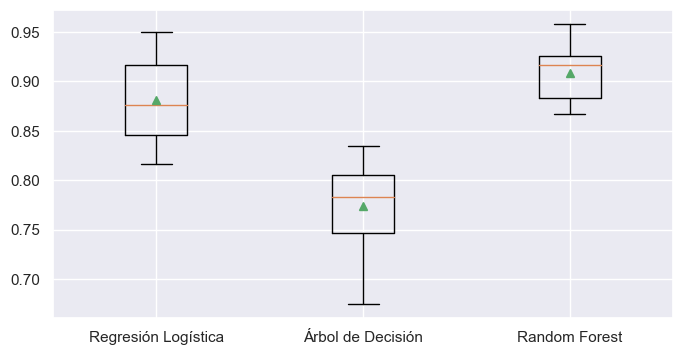

In [14]:
# Inciso 4d: Imprimir tambien los diagramas de caja y bigotes de los tres modelos con la
# métrica “recall”.
sns.set(rc={'figure.figsize':(8,4)})
boxPlotsRecall = list()
for i in range(len(resultados)):
  rr = resultados[i]['test_recall']
  boxPlotsRecall.append(rr)

plt.boxplot(boxPlotsRecall, labels=nombres, showmeans=True)
plt.show()

**¿Alguno de los modelos está subentrenado o sobreentrenado?**

R: El modelo del árbol de decisión esta sobreentrenado. Se puede llegar a esta conclusión debido a que el error de sesgo es alrededor del 20%, mayor al de los otros 2 modelos que se acercan mas al 90% o superior. Ademas como veremos a continuacion la curva de aprendizaje para los datos de entrenamiento tiene un muy buen rendimiento, casi perfecto. Sin embargo, para la curva de los datos de validación se observa que tiene un rendimiento muy por debajo del entrenamiento, por lo que se puede concluir que este modelo está siendo sobreentrenado.


## Curvas de aprendizaje

In [11]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores, title=None, xlabel=None, ylabel=None):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Gráfica las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    if title:
        plt.title(title)
    
    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
        
    # plt.grid()
    plt.legend(loc='lower left')
    plt.show()

### Inciso 4e-i: 
Curva de Aprendizaje utilizando:
- Funcion 'learning_curve()' 
- Hiperparametros predeterminados
- Al menos 20 puntos en la particion del conjunto de entrenamiento

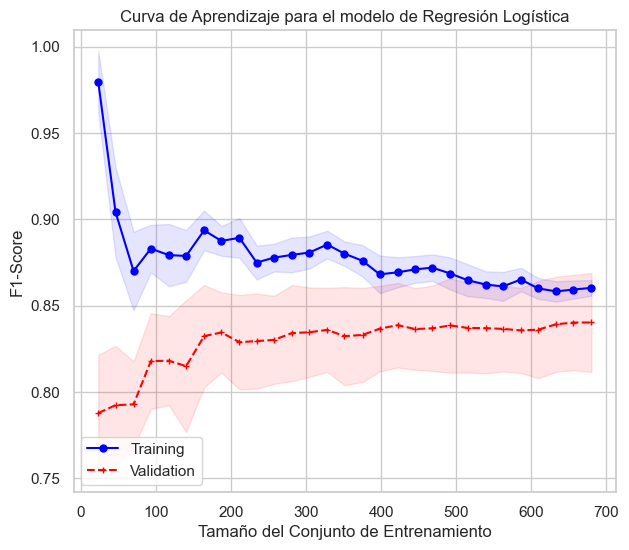

In [20]:
delta_C = np.linspace(0.0001, 1.0, 30),

X_train_transformed = column_transformer.fit_transform(X_train)
cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    train_sizes=delta_C,
    cv=cvLC,
    scoring=make_scorer(my_f1score),
    n_jobs=-1
    # scoring="f1"
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Curva de Aprendizaje para el modelo de Regresión Logística",
                     xlabel="Tamaño del Conjunto de Entrenamiento",
                     ylabel="F1-Score"
                    )


### Inciso 4e-ii: 
Curva de Aprendizaje utilizando:
- Incrementando la complejidad del hiperparametro 'max_depth' del modelo de regresion Arbol de Decision
- Valores de Maxima profundidad de 1 a 20
- Metrica f1-score

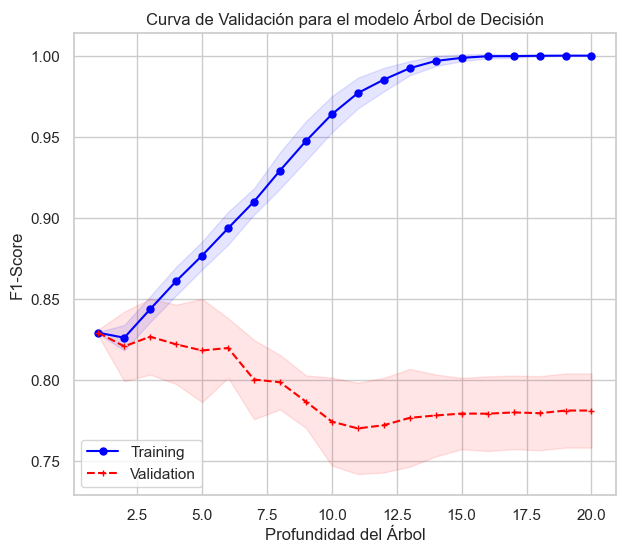

In [14]:
# importante que sea int
delta_D = np.linspace(1, 20, 20, dtype=int)

cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

model = DecisionTreeClassifier(random_state=42)
train_scores, test_scores = validation_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    param_name="max_depth",
    param_range=delta_D,
    cv=cvLC,
    scoring=make_scorer(my_f1score),
    n_jobs=-1,
    error_score="raise"
)

mi_LearningCurvePlot(delta_D, train_scores, test_scores,
                     title="Curva de Validación para el modelo Árbol de Decisión",
                     xlabel="Profundidad del Árbol",
                     ylabel="F1-Score"
                    )

### Inciso 4e-iii: 
Curva de Aprendizaje utilizando:
- Hiperparametros predeteminados para el modelo de regresion bosque aleatorio.
- Al menos 20 puntos en la particion del conjunto de entrenamiento.
- Metrica recall

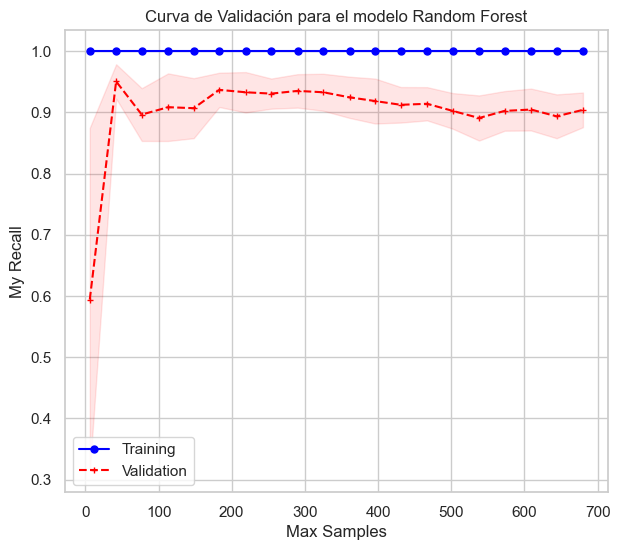

In [22]:
delta_S = np.linspace(0.01, 1, 20)
cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

model = RandomForestClassifier(random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    train_sizes=delta_S,
    cv=cvLC,
    scoring=make_scorer(my_recall),
    n_jobs=-1
    # error_score="raise"
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Curva de Validación para el modelo Random Forest",
                     xlabel="Max Samples",
                     ylabel="My Recall"
                    )

# **Ejercicio-5.**

In [19]:
def evaluate_metrics(model, X_train, y_train, X_val, y_val, metric):
  """Imprimir métricas del modelo"""
  model.fit(X_train, y_train)
  result = model.score(X_val, y_val)
  
  pipe = make_pipeline(model)
  pipe.fit(X_train,y_train)
  yhat = pipe.predict(X_val)

  if metric == 'accuracy':
    print('Accuracy score: %.4f' % pipe.score(X_val, y_val))
  
  if metric == 'precision':
    print('Precision score: %.4f' % my_precision(y_val, yhat))

  if metric == 'recall':  
    print('Recall score: %.4f' % my_recall(y_val, yhat))
  
  if metric == 'f1':
    print('F1 score: %.4f' % my_f1score(y_val, yhat))
  
  if metric == 'gmean':
    print('Gmean score: %.4f' % my_gmean(y_val, yhat))

## Inciso a: 
Para el modelo de regresión logística realizar el entrenamiento buscando sus mejores
hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir en su
búsqueda deben ser al menos los siguientes: 
- C 
- solver 
- class_weight 
- penalty. 
En este caso deberás usar la métrica (scoring) “f1-score”. 

Imprime la mejor combinación de
parámetros obtenidos, así como el valor del mejor desempeño (score) obtenido con la
métrica f1.

NOTA: Toma en cuenta que no todas las combinaciones de “solver” y “penalty” son
posibles, para que lo tomes en cuenta al momento de realizar la búsqueda. Revisa la
documentación. 

In [12]:
def evaluateGridModel(grid, score):    
    print('Mejor valor de {} obtenido con la mejor combinación: {:.5f}'.format(score, grid.best_score_))
    print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
    print('Métrica utilizada:', grid.scoring)

In [16]:
lg_model = LogisticRegression(max_iter=10000)

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l2'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'class_weight': ['balanced', None]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_lg = GridSearchCV(estimator=lg_model,
                    param_grid=parameters,
                    cv=cv,
                    scoring=make_scorer(my_f1score),
                    n_jobs=-1
                    )

grid_lg.fit(X_train_transformed, np.ravel(y_train))

evaluateGridModel(grid_lg, 'f1-Score')

Mejor valor de f1-Score obtenido con la mejor combinación: 0.84446
Mejor combinación de valores encontrados de los hiperparámetros: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Métrica utilizada: make_scorer(my_f1score)


**¿Cuál es la utilidad de la métrica “f1-score”? Incluye tus conclusiones**

R: La utilidad de la métrica f1-score es que permite saber cuál es la media harmónica entre la precisión y la sensibilidad del modelo. Es una métrica muy utilizada para problema binarios como lo es este, aprobacion de crédito o rechazo. Además es muy utilizada para datos que no están balanceados, es decir, los datos de una clase contienen mas datos a diferencia de la otra.

## Inciso b: 
Con los mejores valores de los hiperparámetros encontrados con la métrica “f1-score”
para el modelo de regresión logística, obtener las curvas de aprendizaje (learning curve),
incrementando el tamaño del conjunto de entrenamiento al menos 20 veces.

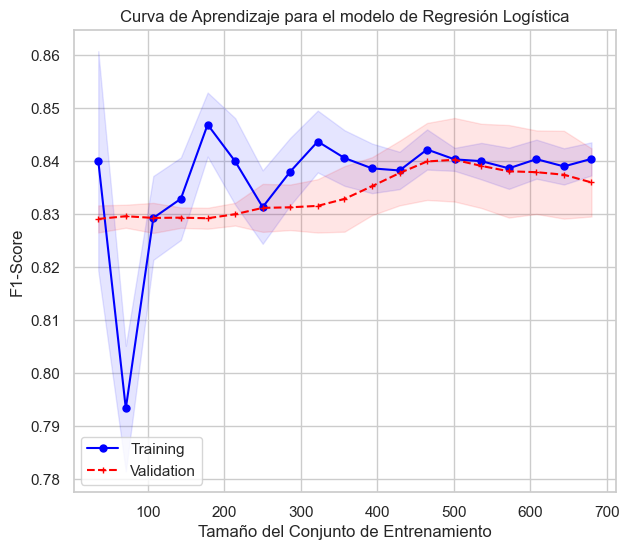

F1 score: 0.7854


In [20]:
delta_C = np.linspace(0.0001, 1.0, 20)
model = LogisticRegression(max_iter=10000, C=0.01, penalty='l2', solver='liblinear')

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    train_sizes=delta_C,
    cv=cv,
    scoring=make_scorer(my_f1score),
    n_jobs=-1
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Curva de Aprendizaje para el modelo de Regresión Logística",
                     xlabel="Tamaño del Conjunto de Entrenamiento",
                     ylabel="F1-Score"
                    )

evaluate_metrics(model, X_train, y_train, Xtest, ytest, 'f1')

## Inciso c: 
Para el modelo de árbol de decisión (decision tree) realizar el entrenamiento buscando
sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir
en su búsqueda deben ser al menos los siguientes: 
- ccp_alpha
- criterion
- max_depth
- min_samples_split
- class_weight. 

En este caso deberás usar la métrica (scoring) “precision”. 

Imprime la mejor combinación de parámetros obtenidos, así como el valor
del mejor desempeño (score) obtenido con la métrica “precision”.

[Cost Desicion Pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

In [30]:
dtc_model = DecisionTreeClassifier()

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 0.99],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [3,4,5,6,7,8,9,10,15,20],
                'min_samples_split': [2,3,4,5,6,7,8,9,10,15,20],
                'class_weight': [None, 'balanced']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_dtc = GridSearchCV(estimator=dtc_model,
                    param_grid=parameters,
                    cv=cv,
                    scoring=make_scorer(my_precision),
                    n_jobs=-1)

grid_dtc.fit(X_train_transformed, np.ravel(y_train))

evaluateGridModel(grid_dtc, 'precision')


Mejor valor de precision obtenido con la mejor combinación: 0.85300
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 7}
Métrica utilizada: make_scorer(my_precision)


**¿Cuál es la utilidad de la métrica “precision”? Incluye tus conclusiones.**

R:  La métrica de precisión permite medir la tasa de predicciones positivas que tuvo el modelo, es decir, del total predicciones de la clase positiva, cuantas de ellas realmente fueron acertadas y no solo falsos positivos? A su vez, es posible definir la tasa de falsas alarmas la cual nos ayuda a identificar aquellos casos donde se realizo una prediccion erronea de nuestro modelo. 

## Inciso d: 
Con los mejores valores de los hiperparámetros encontrados con la métrica “precision”
para el modelo de árbol de decisión, obtener las curvas de aprendizaje (learning curve),
incrementando el tamaño del conjunto de entrenamiento al menos 20 veces.

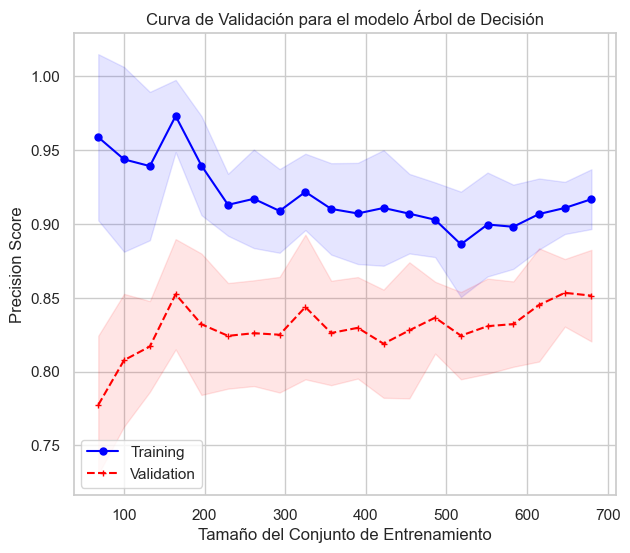

Precision score: 0.7107


In [21]:
delta_C = np.linspace(0.1, 1.0, 20)

cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

dfc = DecisionTreeClassifier(ccp_alpha=0.001, criterion='log_loss', max_depth=4, min_samples_split=7, class_weight='balanced')
train_sizes, train_scores, test_scores = learning_curve(
    dfc,
    X_train_transformed,
    np.ravel(y_train),
    train_sizes=delta_C,
    cv=cvLC,
    scoring=make_scorer(my_precision),
    n_jobs=-1
    # error_score="raise"
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Curva de Validación para el modelo Árbol de Decisión",
                     xlabel="Tamaño del Conjunto de Entrenamiento",
                     ylabel="Precision Score"
                    )

evaluate_metrics(model, X_train, y_train, Xtest, ytest, 'precision')


## Inciso e: 
Para el modelo de bosque aleatorio (random forest) realizar el entrenamiento buscando
sus mejores hiperparámetros con GridSearchCV(). Los hiperparámetros que debes incluir
en su búsqueda deben ser al menos los siguientes: 
- ccp_alpha 
- criterion 
- max_depth,
- min_samples_split 
- class_weight. 

En este caso deberás usar la métrica (scoring) “recall”.
Imprime la mejor combinación de parámetros obtenidos, así como el valor del mejor
desempeño (score) obtenido con la métrica “recall”.

In [27]:
rfc_model = RandomForestClassifier()

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 0.99],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [3,4,5,6,7,8,9,10],
                'min_samples_split': [2,3,4,5,6,7,8,9,10],
                'class_weight': [None, 'balanced', 'balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_rfc = GridSearchCV(
  estimator=rfc_model,
  param_grid=parameters,
  cv=cv,
  scoring=make_scorer(my_recall),
  n_jobs=-1
) # parallel jobs in CPU

grid_rfc.fit(X_train_transformed, np.ravel(y_train))

evaluateGridModel(grid_rfc, 'recall')


Mejor valor de recall obtenido con la mejor combinación: 1.00000
Mejor combinación de valores encontrados de los hiperparámetros: {'ccp_alpha': 0.1, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Métrica utilizada: make_scorer(my_recall)


**¿Cuál es la utilidad de la métrica “recall”? Incluye tus conclusiones.**

R: La métrica de recall o también conocida como sensibilidad permite medir que tan correctas fueron las predicciones que tuvo el modelo, es decir, del total de datos que realmente son candidatos para tener un crédito, cuántos fueron pronosticados correctamente. Mientras mas alto sea nuestro resultado de recall mas alto es el numero de creditos otorgados de manera correcta en nuestro modelo.

## Inciso f: 
Con los mejores valores de los hiperparámetros encontrados con la métrica “recall” para
el modelo de bosque aleatorio, obtener las curvas de validación (validation curve),
incrementando la complejidad del modelo a través del hiperparámetro “max_depth” con
al menos 10 valores

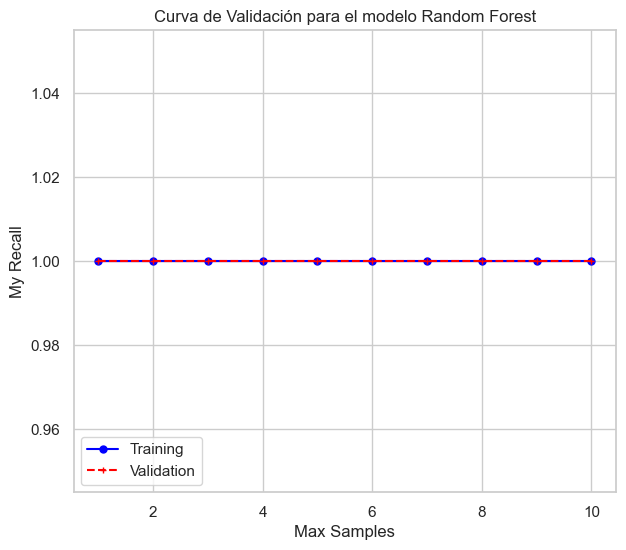

Recall score: 1.0000


In [22]:
delta_MD = np.linspace(1, 10, 10, dtype=int)


cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

model = RandomForestClassifier(
    ccp_alpha=0.1, 
    criterion="gini",    
    max_depth=3, 
    min_samples_split=2    
)
train_scores, test_scores = validation_curve(
    model,
    X_train_transformed,
    y_train,
    param_name="max_depth",
    param_range=delta_MD,
    cv=cvLC,
    scoring="recall",
    n_jobs=-1,
    error_score="raise",
)

mi_LearningCurvePlot(delta_MD, train_scores, test_scores,
                     title="Curva de Validación para el modelo Random Forest",
                     xlabel="Max Samples",
                     ylabel="My Recall"
                    )

evaluate_metrics(model, X_train, y_train, Xtest, ytest, 'recall')                    

# **Ejercicio-6.**

Para cada uno de estos tres modelos, con las métricas que se consideraron en cada caso y usando
el conjunto de Prueba que no has utilizado hasta ahora, obtener los modelos finales como se te
indica a continuación. Deberás usar además como conjunto de entrenamiento el llamado modelo
de entrenamiento “aumentado” que consiste en las datos que estuviste utilizando para
entrenamiento y validación:

## Inciso a:
Obtener el modelo de regresión logística con los mejores parámetros que hayas
encontrado con la métrica f1-score utilizada. Imprimir el valor de dicha métrica e incluye
tus conclusiones finales para este caso. Incluir un gráfico del árbol de decisión final
obtenido.

In [23]:
LR_model = LogisticRegression(
  max_iter=10000, C=0.01, penalty='l2', solver='liblinear'
)

pipe = make_pipeline((LR_model))
pipe.fit(X_train, y_train)
yhat = pipe.predict(Xtest)


print('F1-Score score: %.4f'  %  my_f1score(ytest, yhat) )


F1-Score score: 0.7854


El modelo de regresión logística es un buen modelo sencillo para este problema, ya que nos permite obtener un buen resultado de f1-score, el cual es de 0.78.
No tiene los mejores resultados de los tres modelos, pero si es el que menos tiempo de ejecución tiene.

## Inciso b:
Obtener el modelo de árbol de decisiones con los mejores parámetros que hayas
encontrado con la métrica “precision” utilizada. Imprimir el valor de dicha métrica e
incluye tus conclusiones finales para este caso.

In [24]:
DTC_model = DecisionTreeClassifier(
  ccp_alpha=0.001, criterion='log_loss', max_depth=4, min_samples_split=7, class_weight='balanced'
)
# X_train, Xtest, y_train, ytest = train_test_split(X, y, train_size=0.85, random_state=10)


pipe = make_pipeline((DTC_model))
pipe.fit(X_train, y_train)
yhat = pipe.predict(Xtest)


print('Precision score: %.4f' %  my_precision(ytest, yhat) )


Precision score: 0.8769


In [33]:
from sklearn import tree
import pydotplus 
from IPython.display import Image

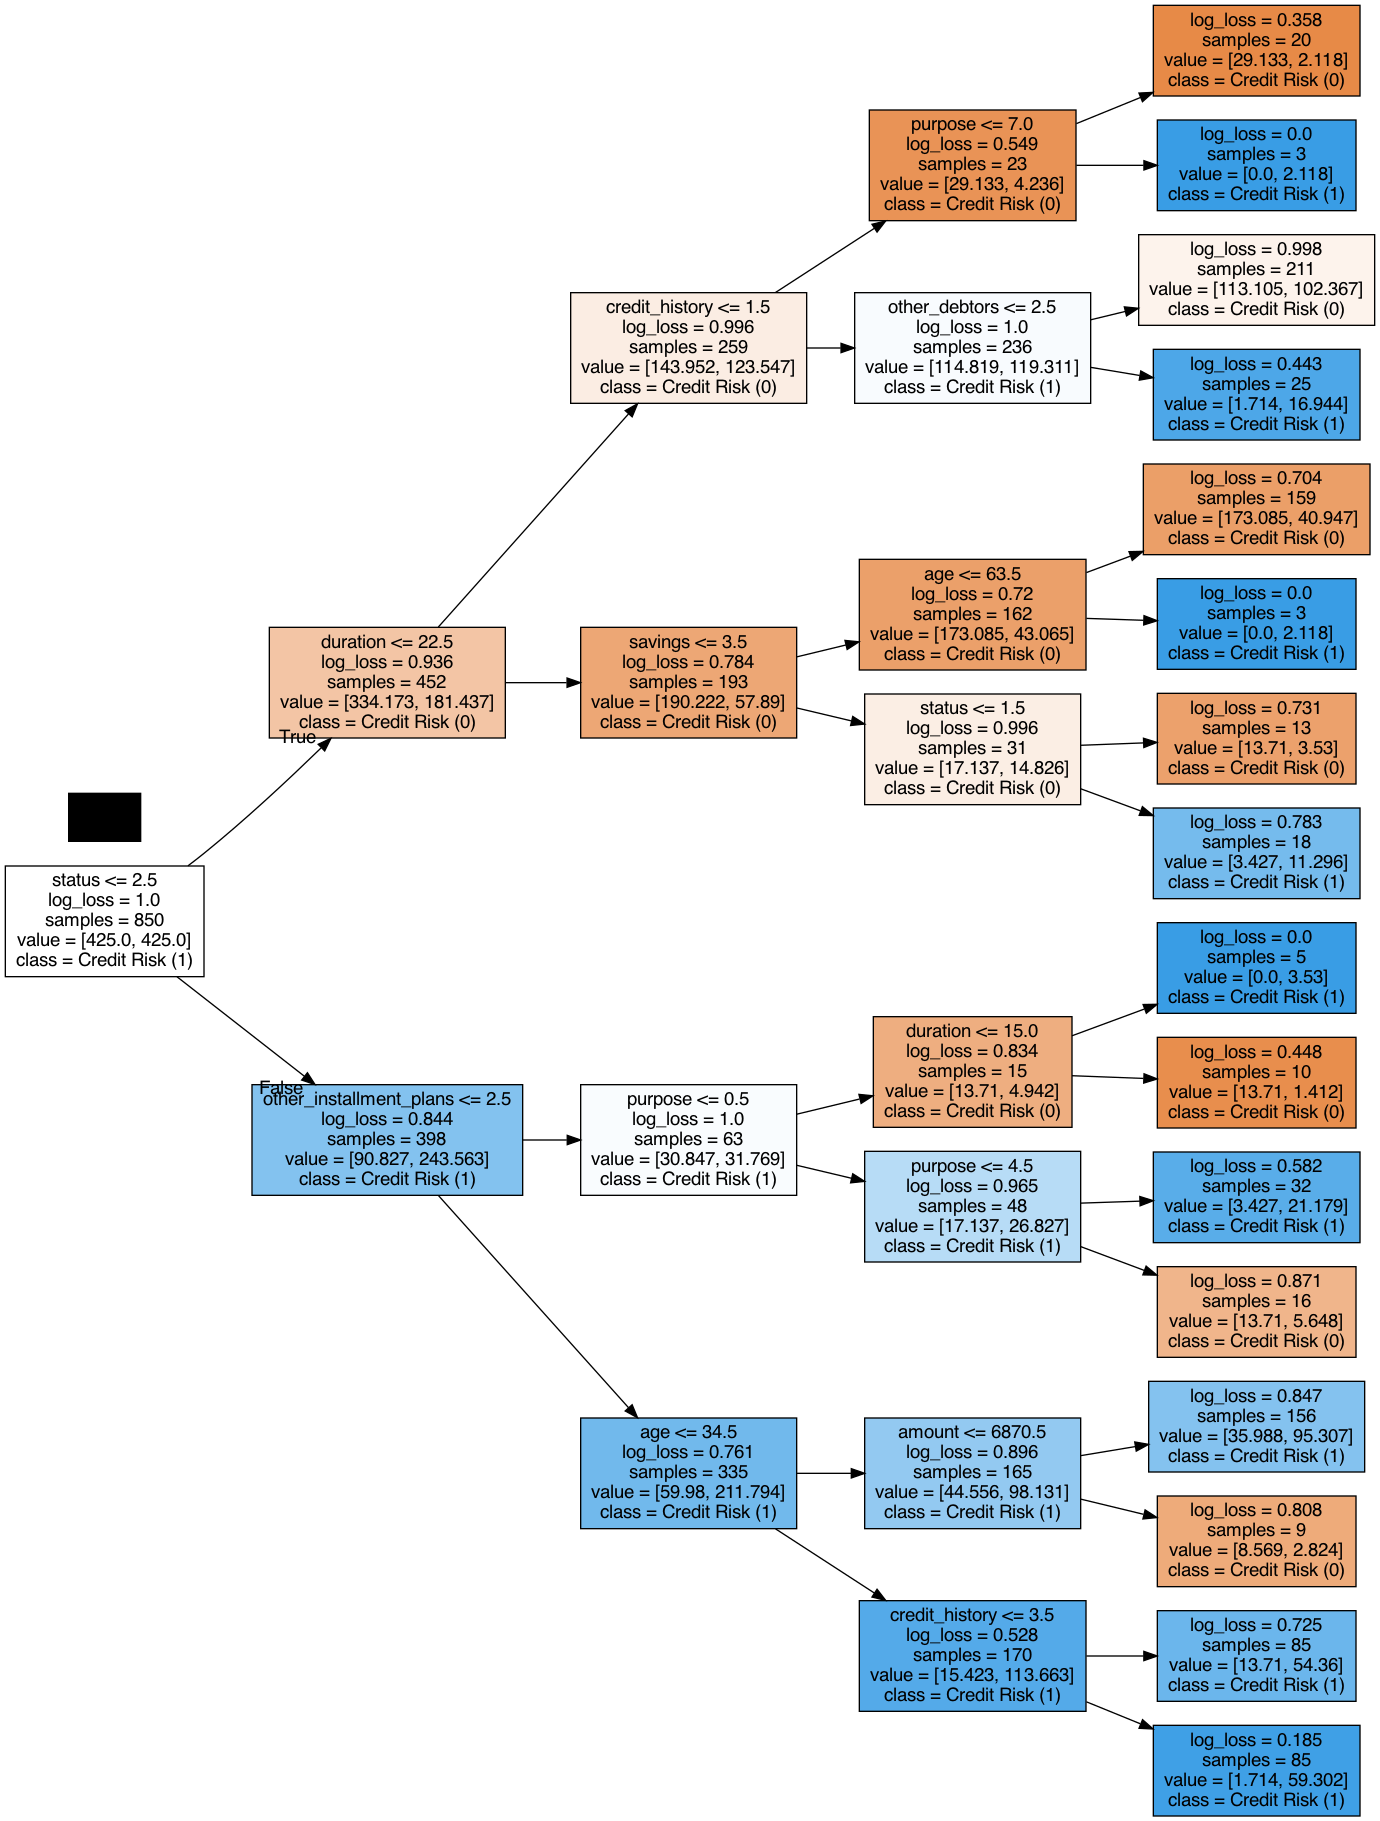

In [34]:
dot_data = tree.export_graphviz(decision_tree=DTC_model, 
                                out_file=None,
                                max_depth=None,
                                feature_names=list(pd.DataFrame(X_train).columns.values),
                                class_names=['Credit Risk (0)', 'Credit Risk (1)'],
                                filled=True,
                                rotate=True,
                                proportion=False)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

En conclusión, se observó que después de afinar los hiperparámetros para el modelo del árbol de decisión, se arreglo el problema del sobre entrenamiento y no solo eso, la métrica con la que se midió el modelo, precisión, obtuvo un mejor resultado que el primer modelo con parámetros sin cambiar. La razón de esto es que un solo árbol de decisión es muy susceptible a ser sobre entrenado o sub entrenado dependiendo de que orden lleguen los datos de entrenamiento por lo que si no hay un afinamiento de parámetros este problema siempre aparecerá al momento de hacer análisis con este modelo.

## Inciso c:
Obtener el modelo de bosque aleatorio con los mejores parámetros que hayas
encontrado con la métrica “recall” utilizada. Imprimir el valor de dicha métrica e incluye
tus conclusiones finales para este caso.

In [25]:
RF_model = RandomForestClassifier(
    ccp_alpha=0.1, 
    criterion="gini",    
    max_depth=3, 
    min_samples_split=2
)

pipe = make_pipeline((RF_model))
pipe.fit(X_train, y_train)
yhat = pipe.predict(Xtest)


print('Recall score: %.4f'    %  my_recall(ytest, yhat) )


Recall score: 1.0000


En conclusión, para el modelo del bosque de arboles aleatorio se vio una mejora perfecta del modelo a diferencia de entrenar el modelo inicial sin cambiar parámetros. Se puede observar con los primeros gráficos, se puede observar con la curva de aprendizaje y finalmente con la métrica de recall (sensibilidad) puesto que se obtiene una métrica de 1, lo que indica que el modelo fue capaz de identificar todos los datos que si eran candidatos para tener un crédito. Como se tienen la seguridad de que no hay data leakage en nuestro análisis, se puede concluir que este modelo generaliza muy bien este problema y este listo para generalizar nuevos datos adquiridos.

### **Fin de la Actividad de la semana 6.**